In [1]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import matplotlib.pyplot as plt

In [38]:
from cfollmer.evaluation_utils import ECE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class LeNet5(torch.nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=120),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [4]:
MNIST_train = datasets.MNIST("../data/mnist/", download=True, transform=ToTensor(), train=True)
MNIST_test = datasets.MNIST("../data/mnist/", download=True, transform=ToTensor(), train=False)

In [23]:
model = LeNet5(10).to(device)
func_model, params = functorch.make_functional(model)
param_sizes = [p.shape for p in params]
dim = sum([math.prod(s)for s in param_sizes])
N = len(MNIST_train)

idx_to = np.cumsum([math.prod(s) for s in param_sizes])
idx_from = np.zeros(len(idx_to), dtype=int)
idx_from[1:] = idx_to[:-1]

def get_params_from_array(array):
    return [array[idx_from[i]:idx_to[i]].reshape(s) for i, s in enumerate(param_sizes)]
    
sigma2 = 0.1

def log_prior(params):
    return -torch.sum(params**2) / (2 * sigma2)

def log_likelihood(x, y, params):
    preds = func_model(get_params_from_array(params), x)
    return -F.cross_entropy(preds, y, reduction="sum")

def log_posterior(x, y, params):
    return log_prior(params) + (N / x.shape[0]) * log_likelihood(x, y, params)

def log_posterior_batch(x, y, params_batch):
    func = lambda params: log_posterior(x, y, params)
    func = functorch.vmap(func)
    return func(params_batch)

In [6]:
class SDE(torch.nn.Module):
    
    def __init__(self, gamma, input_dim, width=300):
        super().__init__()
        activation = torch.nn.Softplus
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, input_dim)
        )
        
        self.nn[-1].weight.data.fill_(0)
        self.nn[-1].bias.data.fill_(0)
        
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        self.gamma = gamma
    
    def f(self, t, params_batch):
        t_ = t * torch.ones((params_batch.shape[0], 1), device=params_batch.device)
        return self.nn(torch.cat((t_, params_batch), dim=-1))
    
    def g(self, t, params_batch):
        return torch.sqrt(self.gamma * torch.ones_like(params_batch))

In [7]:
gamma = 0.1**2
sde = SDE(gamma, dim).to(device)

optimizer = torch.optim.Adam(sde.parameters(), lr=1e-5)

n_epochs = 10
data_batch_size = 32
param_batch_size = 32

In [8]:
dataloader_train = DataLoader(MNIST_train, shuffle=True, batch_size=data_batch_size, num_workers=2)
dataloader_test = DataLoader(MNIST_test, shuffle=False, batch_size=data_batch_size, num_workers=2)

In [9]:
def loss(sde, x, y, dt=0.05):
    n_steps = int(1.0 / dt)
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    param_init = torch.zeros((param_batch_size, dim), device=device)
    param_trajectory = torchsde.sdeint(sde, param_init, ts, method="euler", dt=dt)
    param_T = param_trajectory[-1]
    
    fs = functorch.vmap(sde.f)(ts, param_trajectory)
    
    energy_cost = torch.sum(fs**2, dim=[0, 2]) * dt  / (2 * gamma)
    terminal_cost = - torch.sum(param_T**2, dim=1) / (2 * gamma) - log_posterior_batch(x, y, param_T)
    
    return torch.mean(energy_cost + terminal_cost)

In [14]:
losses = []

for _ in range(n_epochs):
    epoch_losses = []
    for x, y in tqdm(iter(dataloader_train)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        l = loss(sde, x, y, dt=0.05)
        l.backward()
        epoch_losses.append(l.detach().cpu().numpy())
        optimizer.step()
        
    losses.append(epoch_losses)

100%|████████████████████████████████████████████████████████████| 1875/1875 [01:49<00:00, 17.07it/s]


In [15]:
losses = np.array(losses)

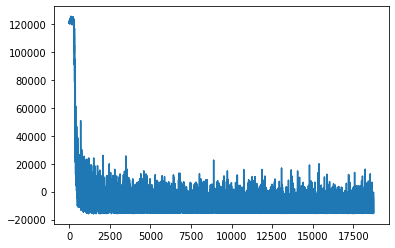

In [16]:
plt.plot(losses.flatten())

In [17]:
torch.save(sde.state_dict(), "bnn_sde_0_init.pt")

In [10]:
sde.load_state_dict(torch.load("bnn_sde_0_init.pt"))

<All keys matched successfully>

In [11]:
with torch.no_grad():
    dt = 0.005
    n_steps = int(1.0 / dt)
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    param_init = torch.zeros((200, dim), device=device)
    param_trajectory = torchsde.sdeint(sde, param_init, ts, method="euler", dt=dt)
    param_samples = param_trajectory[-1]

In [12]:
all_predictions = []
all_confidences = []

for x, y in tqdm(iter(dataloader_test)):
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        predict_func = lambda params : func_model(get_params_from_array(params), x)
        predict_func = functorch.vmap(predict_func)
        
        out = F.softmax(predict_func(param_samples), dim=-1)
        out = torch.mean(out, dim=0)
        confidences, predictions = torch.max(out, dim=1)
        
        all_predictions.append(predictions)
        all_confidences.append(confidences)

100%|█████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 408.17it/s]


In [13]:
all_predictions = torch.hstack(all_predictions).cpu().numpy()
all_confidences = torch.hstack(all_confidences).cpu().numpy()
true_labels = MNIST_test.targets.numpy()

In [14]:
np.mean(all_predictions == true_labels)

0.9876

In [17]:
ECE(all_confidences, all_predictions, true_labels)

0.008097228735685361

SGLD from here onwards

In [9]:
@torch.enable_grad()
def gradient(x, y, params):
    params_ = params.clone().requires_grad_(True)
    loss = log_posterior(x, y, params_)
    grad, = torch.autograd.grad(loss, params_)
    return loss.detach().cpu().numpy(), grad

In [29]:
def step_size(n):
    return 0.0001 / (1 + n)**0.5

In [39]:
params = 0.001 * torch.randn(dim).float().to(device)
n_epochs = 5

In [40]:
step = 0

losses = []

for _ in range(n_epochs):
    epoch_losses = []
    for x, y in tqdm(iter(dataloader_train)):
        x = x.to(device)
        y = y.to(device)
        
        eps = step_size(step)
        loss, grad = gradient(x, y, params)
        params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
        step += 1
        epoch_losses.append(loss)
    losses.append(epoch_losses)

100%|███████████████████████████████████████████████████████████| 1875/1875 [00:03<00:00, 550.60it/s]


In [41]:
losses = np.array(losses)

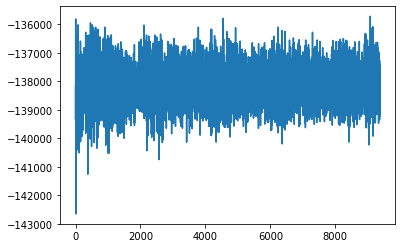

In [42]:
plt.plot(losses.flatten())

In [43]:
all_predictions = []
all_confidences = []

for x, y in tqdm(iter(dataloader_test)):
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        out = func_model(get_params_from_array(params), x)
        out = F.softmax(out, dim=-1)
        confidences, predictions = torch.max(out, dim=1)
        
        all_predictions.append(predictions)
        all_confidences.append(confidences)

100%|█████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 656.59it/s]


In [44]:
all_predictions = torch.hstack(all_predictions).cpu().numpy()
all_confidences = torch.hstack(all_confidences).cpu().numpy()
true_labels = MNIST_test.targets.numpy()

In [45]:
np.mean(all_predictions == true_labels)

0.1135

In [46]:
ECE(all_confidences, all_predictions, true_labels)

0.00013981854915619263

In [ ]:
ECE()

In [165]:
params_samples = []
train_iter = iter(dataloader_train)
for i in range(50):
    x, y = next(train_iter)
    x = x.to(device)
    y = y.to(device)
        
    eps = step_size(step)
    loss, grad = gradient(x, y, params)
    params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
    step += 1
    params_samples.append(params)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48dd976670>
Traceback (most recent call last):
  File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48dd976670>
Traceback (most recent call last):
  File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  

In [166]:
params_samples = torch.stack(params_samples)

In [167]:
all_predictions = []
all_confidences = []

for x, y in tqdm(iter(dataloader_test)):
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        predict_func = lambda params : func_model(get_params_from_array(params), x)
        predict_func = functorch.vmap(predict_func)
        
        out = F.softmax(predict_func(params_samples), dim=-1)
        out = torch.mean(out, dim=0)
        confidences, predictions = torch.max(out, dim=1)
        
        all_predictions.append(predictions)
        all_confidences.append(confidences)

  0%|                                                                        | 0/313 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48dd976670>
Traceback (most recent call last):
  File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48dd976670>
Traceback (most recent call last):
  File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8

In [168]:
all_predictions = torch.hstack(all_predictions).cpu().numpy()
all_confidences = torch.hstack(all_confidences).cpu().numpy()
true_labels = MNIST_test.targets.numpy()

In [169]:
np.mean(all_predictions == true_labels)

0.9858

In [170]:
ECE(all_confidences, all_predictions, true_labels)

0.003385664606094435

In [11]:
model = LeNet5(10).to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.001)

for i in range(n_epochs):
    for x, y in tqdm(iter(dataloader_train)):
        optim.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        outs = model(x)
        loss = F.cross_entropy(outs, y, reduction="mean")
        
        loss.backward()
        optim.step()

100%|███████████████████████████████████████████████████████████| 1875/1875 [00:02<00:00, 679.76it/s]


In [13]:
acc = 0

with torch.no_grad():
    for x, y in tqdm(iter(dataloader_test)):
        x = x.to(device)
        y = y.to(device)

        outs = model(x)
        print(outs.shape)
        
        preds = torch.argmax(outs, dim=1)
        print(preds.shape)
        acc = acc + torch.sum(preds == y)

  0%|                                                                        | 0/313 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7d1798670>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7d1798670>  File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

Traceback (most recent call last):
      File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
self._shutdown_workers()
      File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torc

torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([

 98%|███████████████████████████████████████████████████████████▊ | 307/313 [00:00<00:00, 809.68it/s]

torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
torch.Size([32, 10])
torch.Size([

100%|█████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 619.39it/s]


In [14]:
acc / len(MNIST_test)

tensor(0.8733, device='cuda:0')